In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from datahandling import BcomMEG

In [2]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
epo_files = []
subjects = ['BCOM_18_2'] # focus on one because the head thing for the mutliple trials is not working atm. 
avoid_reading = True
data = BcomMEG(dir=dir, subjects=subjects, avoid_reading=avoid_reading)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_116-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
16 matching events found
No baseline correct

In [3]:
# first, sepreate out the conditions
a_labels = [a for a in data.data['BCOM_18_2'].keys() if 'a' in a]
e_labels = [e for e in data.data['BCOM_18_2'].keys() if 'e' in e]
i_labels = [i for i in data.data['BCOM_18_2'].keys() if 'i' in i]

for subject in data.data:
    a_epochs = mne.concatenate_epochs([data.data[subject][a] for a in a_labels])
    e_epochs = mne.concatenate_epochs([data.data[subject][e] for e in e_labels])
    i_epochs = mne.concatenate_epochs([data.data[subject][i] for i in i_labels])    


Not setting metadata
178 matching events found
No baseline correction applied
Not setting metadata
108 matching events found
No baseline correction applied
Not setting metadata
123 matching events found
No baseline correction applied


In [196]:
# first, sepreate out the conditions
a_labels = []
e_labels = []
i_labels = []
for subject in data.data.keys():
    for condition in data.data[subject].keys():
        if 'a' in condition:
            a_labels.append(condition)
        elif 'e' in condition:
            e_labels.append(condition)
        elif 'i' in condition:
            i_labels.append(condition)

a_labels = set(a_labels)
i_labels = set(i_labels)
e_labels = set(e_labels)

a_epochs = []
e_epochs = []
i_epochs = []

for subject in data.data:
    a_epochs.append(mne.concatenate_epochs([data.data[subject][a] for a in a_labels if a in data.data[subject].keys()]))
    e_epochs.append(mne.concatenate_epochs([data.data[subject][e] for e in e_labels if e in data.data[subject].keys()]))
    i_epochs.append(mne.concatenate_epochs([data.data[subject][i] for i in i_labels if i in data.data[subject].keys()]))

a_epochs = mne.concatenate_epochs(a_epochs)
e_epochs = mne.concatenate_epochs(e_epochs)
i_epochs = mne.concatenate_epochs(i_epochs)

Not setting metadata
178 matching events found
No baseline correction applied
Not setting metadata
108 matching events found
No baseline correction applied
Not setting metadata
123 matching events found
No baseline correction applied
Not setting metadata
141 matching events found
No baseline correction applied
Not setting metadata
126 matching events found
No baseline correction applied
Not setting metadata
142 matching events found
No baseline correction applied


ValueError: epochs[1].info['dev_head_t'] differs. The instances probably come from different runs, and are therefore associated with different head positions. Manually change info['dev_head_t'] to avoid this message but beware that this means the MEG sensors will not be properly spatially aligned. See mne.preprocessing.maxwell_filter to realign the runs to a common head position.

In [ ]:
from mne.stats import permutation_cluster_test

permuataion_collection = [a_epochs.get_data(), e_epochs.get_data(), i_epochs.get_data()]
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(permuataion_collection, n_permutations=2000, tail=0)

In [ ]:
significant_sensors = np.where(cluster_p_values < 0.05)[0]

array([], dtype=int64)

In [132]:
significant_sensors

array([], dtype=int64)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

num_a = len(a_epochs)
num_e = len(e_epochs)
num_i = len(i_epochs)
min_trials = (min(num_a, num_e, num_i))

a_rand = a_epochs[np.random.choice(num_a, min(num_a, num_e, num_i), replace=False)]
e_rand = e_epochs[np.random.choice(num_e, min(num_a, num_e, num_i), replace=False)]
i_rand = i_epochs[np.random.choice(num_i, min(num_a, num_e, num_i), replace=False)]

a_data = a_rand.get_data()
e_data = e_rand.get_data()
i_data = i_rand.get_data()

a_flat = a_data.reshape(a_data.shape[0], -1)
e_flat = e_data.reshape(e_data.shape[0], -1)
i_flat = i_data.reshape(i_data.shape[0], -1)


X = np.vstack([a_flat, e_flat, i_flat])
y = np.concatenate([np.ones(min_trials), np.ones(min_trials)*2, np.ones(min_trials)*3])
mi_scores = mutual_info_classif(X, y, random_state=0)
important_sensors = np.argsort(mi_scores)[-10:]



In [ ]:
mi_reshaped = mi_scores.reshape(a_data.shape[1], a_data.shape[2])
sensor_mi_scores_reshaped = mi_reshaped.mean(axis=1)
important_sensors = np.argsort(sensor_mi_scores_reshaped)[-10:]
sensor_names = a_epochs.info['ch_names']
important_sensor_names = [sensor_names[i] for i in important_sensors]
print(important_sensor_names)
sensor_mi_scores_reshaped[important_sensors]


In [ ]:
import mne.channels


important_sensor_names
sensor_mi_scores_reshaped[important_sensors]

info = a_epochs.info
picks = mne.pick_channels(info['ch_names'], include=important_sensor_names)

pos = mne.channels.layout._find_topomap_coords(info, picks)

data = np.array(sensor_mi_scores_reshaped[important_sensors])

fig, ax = plt.subplots()
mne.viz.plot_topomap(data, pos, axes=ax, show=False, cmap='viridis', contours=0)

In [5]:
import pywt

def scalogram_dereconstruction(data, wavelet='db4', level=7):
    # First decompose
    coefficients = pywt.wavedec(data, wavelet, level=level)
    coefficients[-1] = np.zeros_like(coefficients[-1]) #d1 #get rid of these two as in Dash et al 2020.
    coefficients[-2] = np.zeros_like(coefficients[-2]) #d2
    # Reconstruct
    reconstructed_signal = pywt.waverec(coefficients, wavelet)[:len(data)]
    return reconstructed_signal

def scalogram_cwt(processed_data, wavelet, B, C, sampling_rate, log_samples):
    wavelet = f'{wavelet}{B}-{C}'
    sampling_period = 1/sampling_rate
    frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), log_samples)
    scales = pywt.central_frequency(wavelet=wavelet)/ (frequencies * sampling_period)
    coefficients, _ = pywt.cwt(data=processed_data, scales=scales, wavelet=wavelet, sampling_period=sampling_period)
    return coefficients




In [ ]:

print(a_data.shape) # epochs, sensors, time


#Precompute to hopefully make it faster. In any case, this is super easy to parallelize.
log_samples = 100
a_coefficients = np.zeros([a_data.shape[0], a_data.shape[1], log_samples, a_data.shape[2]])
print(a_coefficients.shape)
wavelet = 'cmor1.0-1.0'
sampling_rate = 300
sampling_period = 1/sampling_rate
frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), log_samples)
scales = pywt.central_frequency(wavelet=wavelet)/ (frequencies * sampling_period)

for epoch, _ in enumerate(a_data): # ALMOST 6 MINUTES FOR 108 EPOCHS!! Parrallelize this or it will take forever. 
    # print(epoch)
    for channel, _ in enumerate(a_data[epoch]):
        # print(a_data[epoch][channel])
        reconstructed_signal = scalogram_dereconstruction(a_data[epoch][channel], wavelet='db4', level=5) # this doesn't change dims so might be possible to map
        # print(reconstructed_signal.shape)
        coefficients, _ = pywt.cwt(data=reconstructed_signal, scales=scales, wavelet=wavelet, sampling_period=sampling_period)
        # print(coefficients.shape) # log_samplesx241
        a_coefficients[epoch][channel] = abs(coefficients)
    #     print(a_coefficients)
    #     break
    # break

(108, 247, 241)
(108, 247, 100, 241)


In [ ]:
np.save('a_coefficients.npy', a_coefficients) # 17 seconds and about 5GB - compression doesn't help for storage and takes way longer

In [9]:
all_categories = [a_data, e_data, i_data]

In [ ]:
# Ok so this works, but run with extreme caution or it will crash your computer! Would be better to do it on the cluster I think, but at least for testing it worked (and I saved the results lol)
from joblib import Parallel, delayed

def process_epoch(epoch_data, scales, wavelet, sampling_period, log_samples):
    '''Takes in an entire epoch and processes it into scalogram coefficients'''
    epoch_coefficients = np.zeros([epoch_data.shape[0], log_samples, epoch_data.shape[1]]) # channels, scales, time for each epoch
    epoch_data = np.array(epoch_data, copy=True) # Make the array writable
    
    for channel, channel_data in enumerate(epoch_data):
        reconstructed_signal = scalogram_dereconstruction(channel_data, wavelet='db4', level=5)
        coefficients, _ = pywt.cwt(data=reconstructed_signal, scales=scales, wavelet=wavelet, sampling_period=sampling_period)
        epoch_coefficients[channel] = abs(coefficients)
    
    return epoch_coefficients

def process_categories(data, scales, wavelet, sampling_period, log_samples):
    '''Takes in an entire category and processes it into scalogram coefficients'''
    results = Parallel(n_jobs=3)(
        delayed(process_epoch)(
            epoch_data=data[category],
            scales=scales,
            wavelet=wavelet,
            sampling_period=sampling_period,
            log_samples=log_samples
        ) for category in range(len(data))
    )
    return np.array(results)


results = Parallel(n_jobs=3)(
    delayed(process_categories)(
        data=data_array, 
        scales=scales, 
        wavelet=wavelet, 
        sampling_period=sampling_period, 
        log_samples=log_samples
    ) for data_array in all_categories
)

a_coefficients, e_coefficients, i_coefficients = results

In [ ]:
# np.save('a_coefficients_18_2_Feb10.npy', a_coefficients)
# np.save('e_coefficients_18_2_Feb10.npy', e_coefficients)
# np.save('i_coefficients_18_2_Feb10.npy', i_coefficients)

## Random Forest

This is just not going to work though is it? Since the classifier itself can't do the task, it feels like the end outcome will just be that the feature importance is totally unreliable.

In [ ]:
a_coefficients.shape # epochs, channels, scales, time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### aggregate over time
a_coefs_rf = np.var(a_coefficients, axis=3)
e_coefs_rf = np.var(e_coefficients, axis=3)
i_coefs_rf = np.var(i_coefficients, axis=3)

### aggregate over scales 
a_coefs_rf_agg = np.median(a_coefs_rf, axis=2)
e_coefs_rf_agg = np.median(e_coefs_rf, axis=2)
i_coefs_rf_agg = np.median(i_coefs_rf, axis=2)

In [69]:
y = np.concatenate([np.ones(a_coefs_rf.shape[0]), np.ones(e_coefs_rf.shape[0])*2, np.ones(i_coefs_rf.shape[0])*3])
X = np.vstack([a_coefs_rf_agg, e_coefs_rf_agg, i_coefs_rf_agg])

clf = RandomForestClassifier(n_estimators=150, random_state=1)
scores = cross_val_score(clf, X, y, cv=10)
print(scores.mean(), scores.std())
clf.fit(X, y)
importance = clf.feature_importances_

important_sensors = np.argsort(importance)[-9:]




0.3270833333333333 0.012499999999999997


## Mutual Information

Can do something simpler by just considering the mutual information? I think this is probably just the best way if we go a statistical approach.

(But we should probably do the anatomical one, tbh. I think in terms of justification, it is the only one that really makese sense - everything else is kinda hand wavey. Maybe if the training pipeline is fine we can go back and redo it after 
capturing the saliency information)


In [ ]:
from sklearn.feature_selection import mutual_info_classif

### aggregate over time
a_coefs_rf = np.var(a_coefficients, axis=3)
e_coefs_rf = np.var(e_coefficients, axis=3)
i_coefs_rf = np.var(i_coefficients, axis=3)

### aggregate over scales 
a_coefs_rf_agg = np.median(a_coefs_rf, axis=2)
e_coefs_rf_agg = np.median(e_coefs_rf, axis=2)
i_coefs_rf_agg = np.median(i_coefs_rf, axis=2)

y = np.concatenate([np.ones(a_coefs_rf.shape[0]), np.ones(e_coefs_rf.shape[0])*2, np.ones(i_coefs_rf.shape[0])*3])
X = np.vstack([a_coefs_rf_agg, e_coefs_rf_agg, i_coefs_rf_agg])
mi_scores = mutual_info_classif(X, y, random_state=0, discrete_features=False)

sensor_ranking = np.argsort(mi_scores)[::-1]
print("mi_scores", mi_scores[sensor_ranking]) # and then just take the top 9 from here to make it into a square.

mi_scores [0.08610771 0.08424708 0.08310493 0.07709719 0.07562915 0.07444185
 0.07259788 0.06680287 0.0655053  0.06488212 0.06311801 0.05967551
 0.05741856 0.05395008 0.05355127 0.05289786 0.05221027 0.0519036
 0.05092428 0.05092276 0.04613377 0.04566951 0.04372765 0.0429896
 0.04279715 0.04233035 0.04177412 0.04044389 0.03994461 0.03951325
 0.03905773 0.03846058 0.03834352 0.0372913  0.0358086  0.03491706
 0.03449141 0.03432941 0.03430097 0.03374609 0.03321878 0.03279422
 0.03275176 0.03260614 0.03206718 0.03127067 0.03115993 0.03113517
 0.03112992 0.03056459 0.03047979 0.0303998  0.0302362  0.03011744
 0.03000917 0.02845834 0.02809503 0.02807815 0.02750117 0.02661332
 0.02659263 0.02642037 0.02606436 0.02604224 0.02565306 0.02470418
 0.02435383 0.02353395 0.02344846 0.02281116 0.02097237 0.02022099
 0.01957412 0.01943041 0.0189653  0.01740314 0.01710621 0.01692434
 0.0164138  0.01611502 0.01474133 0.01371121 0.01260802 0.01179993
 0.01143822 0.01122239 0.01106567 0.01102046 0.0107952

In [ ]:
# ### time bins aggregation
# # so if we divide this into 3, then we can just do the same thing as above but with the time bins.
a_clipped = a_coefficients[:, :, :, :240]
e_clipped = e_coefficients[:, :, :, :240]
i_clipped = i_coefficients[:, :, :, :240]

a_first, a_second, a_third = np.array_split(a_clipped, 3, axis=3)
e_first, e_second, e_third = np.array_split(e_clipped, 3, axis=3)
i_first, i_second, i_third = np.array_split(i_clipped, 3, axis=3)

a_first_agg = np.sum(a_first, axis=3)
a_second_agg = np.sum(a_second, axis=3)
a_third_agg = np.sum(a_third, axis=3)

e_first_agg = np.sum(e_first, axis=3)
e_second_agg = np.sum(e_second, axis=3)
e_third_agg = np.sum(e_third, axis=3)

i_first_agg = np.sum(i_first, axis=3)
i_second_agg = np.sum(i_second, axis=3)
i_third_agg = np.sum(i_third, axis=3)



In [161]:
n_epochs, n_channels, n_coeffs = a_first_agg.shape

a_first_flat = a_first_agg.reshape(n_epochs, n_channels*n_coeffs)
a_second_flat = a_second_agg.reshape(n_epochs, n_channels*n_coeffs)
a_third_flat = a_third_agg.reshape(n_epochs, n_channels*n_coeffs)

e_first_flat = e_first_agg.reshape(n_epochs, n_channels*n_coeffs)
e_second_flat = e_second_agg.reshape(n_epochs, n_channels*n_coeffs)
e_third_flat = e_third_agg.reshape(n_epochs, n_channels*n_coeffs)

i_first_flat = i_first_agg.reshape(n_epochs, n_channels*n_coeffs)
i_second_flat = i_second_agg.reshape(n_epochs, n_channels*n_coeffs)
i_third_flat = i_third_agg.reshape(n_epochs, n_channels*n_coeffs)


In [162]:
a_all = np.concatenate([a_first_flat, a_second_flat, a_third_flat], axis=1)
e_all = np.concatenate([e_first_flat, e_second_flat, e_third_flat], axis=1)
i_all = np.concatenate([i_first_flat, i_second_flat, i_third_flat], axis=1)

In [163]:
X = np.vstack([a_all, e_all, i_all])
y = np.concatenate([np.ones(n_epochs), np.ones(n_epochs)*2, np.ones(n_epochs)*3])

mi_scores = mutual_info_classif(X, y, random_state=0, discrete_features=False)
sensor_ranking = np.argsort(mi_scores)[::-1]

In [186]:
mi_sensors = mi_scores_3d.mean(axis=2)  # shape: (3, n_sensors)
best_sensors = np.argmax(mi_sensors, axis=1)
for chunk_idx, sensor_idx in enumerate(best_sensors):
    print(
        f"Chunk {chunk_idx}: best sensor = {sensor_idx}, "
        f"MI={mi_sensors[chunk_idx, sensor_idx]:.3f}"
    )

Chunk 0: best sensor = 93, MI=0.022
Chunk 1: best sensor = 35, MI=0.021
Chunk 2: best sensor = 209, MI=0.021


## Ok so where in the brain?

In [ ]:
import os
subject_dir = os.path.expanduser('~/mne_data/MNE-fsaverage-data')
bem_dir = os.path.expanduser('~/mne_data/MNE-fsaverage-data/')
# head transformation, need to use average because no MRIs
transformation = 'fsaverage'

# standard source space and BEM model - "Boundary Element Method" model. i.e., a realistic head model to use for source localization. 
# apparently it deifnes the el

src = mne.setup_source_space(subject='fsaverage', spacing='oct6', subjects_dir=subject_dir) # 5 mins

bem = mne.make_bem_model(subject='fsaverage', subjects_dir=bem_dir) 

bem = mne.make_bem_solution(bem)

# only for the chosen sensors

picks = mne.pick_channels(info['ch_names'], include=important_sensor_names)

# forward model

fwd = mne.make_forward_solution(info=a_epochs.info, trans=transformation, src=src, bem=bem, eeg=False)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~35.0 MB>
MRI -> head transform : /opt/homebrew/Caskroom/miniconda/base/envs/mne/lib/python3.12/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read 247 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.994570 -0.096133 -0.039854      -2.40 mm
    0.101937 0.977019 0.187196     -35.72 m

In [121]:
# get it for only certain channels

picks = mne.pick_channels(fwd['info']['ch_names'], include=important_sensor_names)
fwd_selected = mne.pick_channels_forward(fwd, include=important_sensor_names)

    10 out of 247 channels remain after picking


In [ ]:
# Computing the inverse model:

noise_cov = mne.compute_covariance(a_epochs, method='auto')

# create an inverse operator to convert signals to brain activity

inv = mne.minimum_norm.make_inverse_operator(info=a_epochs.info, forward=fwd_selected, noise_cov=noise_cov)

Reducing data rank from 247 -> 247
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 28197
log-likelihood on unseen data (descending order):
   shrunk: -1368.100
   empirical: -1368.259
   diagonal_fixed: -1427.716
selecting best estimator: shrunk
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 10 channels.
    10 out of 10 channels remain after picking
Selected 10 channels
Creating the depth weighting matrix...
    10 magnetometer or axial gradiometer channels
    limit = 7980/8196 = 10.006894
    scale = 4.5008

In [5]:
# computing source esitmation

lambda2 = 1.0 / 9.0 # regularization parameter
method = "dSPM" # or "dSPM"

stc = mne.minimum_norm.apply_inverse(a_epochs.average(), inv, lambda2, method)

NameError: name 'inv' is not defined

Hmmm... Idk if this shows what I want it to show...

In [82]:
brain = stc.plot(hemi='split', subjects_dir=subject_dir, subject='fsaverage', time_viewer=True)

Using control points [3.26156745 3.43162634 4.04986332]


qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x17bd27a50> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3d2827b40> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160490780> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160491b10> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160496630> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160497860> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x1604981b0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1

In [39]:
peak_vertex, peak_time = stc.get_peak()
print(f"Peak activation at vertex {peak_vertex} at {peak_time} seconds")

Peak activation at vertex 86178 at 0.21666666666666673 seconds


In [120]:
import mne
import numpy as np

# Read labels for fsaverage (Desikan-Killiany "aparc" parcellation)
labels = mne.read_labels_from_annot(
    subject='fsaverage', 
    parc='aparc', 
    subjects_dir=subject_dir
)

# one of them is missing i guess?
labels = [label for label in labels if 'unknown' not in label.name]

# Extract mean time course from each label
label_ts = mne.extract_label_time_course(
    stc, 
    labels, 
    src=src, 
    mode='mean'
)
# label_ts: shape (n_labels, n_times)

# Find label with largest mean activity over time
mean_act = np.mean(np.abs(label_ts), axis=1)
max_idx = np.argmax(mean_act)
print("Label with strongest average activity:", labels[max_idx].name)

# Also, you can visualize a label-based summary
stc_label = mne.labels_to_stc(
    labels, mean_act, 
    subject='fsaverage'
)
brain = stc_label.plot(
    subject='fsaverage', 
    subjects_dir=subject_dir, 
    hemi='split', 
    time_viewer=True,
    clim={'kind': 'value', 'pos_lims': [0, 0.5, 1]}
)

Reading labels from parcellation...
   read 35 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Extracting time courses for 68 labels (mode: mean)
Label with strongest average activity: lateraloccipital-lh


Well maybe the MI makes sense on just the raw sensor data. But maybe it would make more sense to look at it in terms of the coefficients.

## Ok basically unless some good reason comes up as to why I should do the statistical data driven thing, let's just do anatomical

So, we are looking for Left Inferior Frontal Gyrus, Superior Temporal Gyrus, Middle Temporal Gyrus


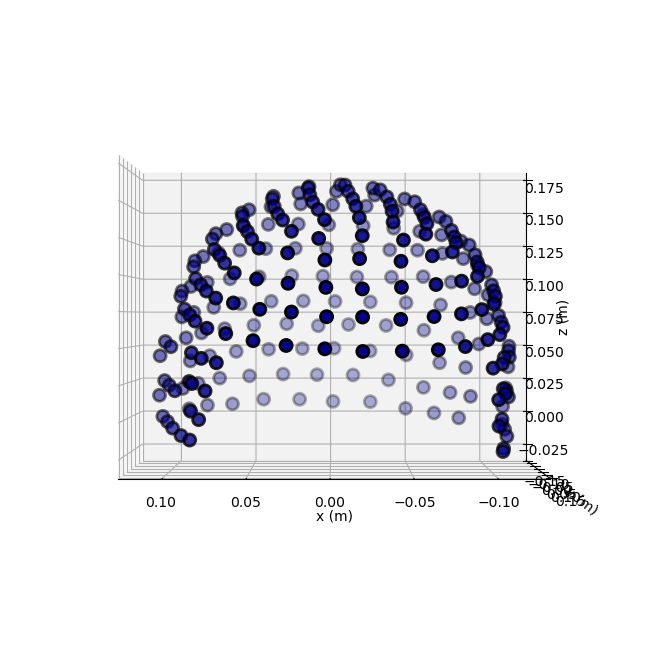

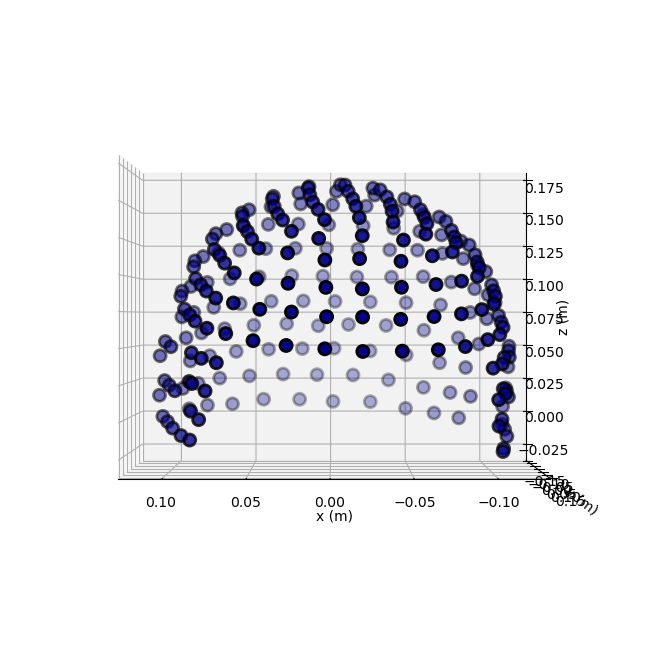

In [194]:
sample = data.data['BCOM_18_2']['i_16']
sample.plot_sensors(kind='3d')


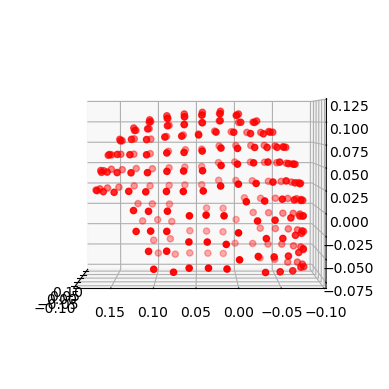

In [46]:
sample = data.data['BCOM_18_2']['re_144']
picks = mne.pick_types(sample.info, meg=True, eeg=False)
sensor_coords = np.array([sample.info['chs'][p]['loc'][:3] for p in picks])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sensor_coords[:, 0], sensor_coords[:, 1], sensor_coords[:, 2], c='r', marker='o')
ax.view_init(elev=2, azim=180)  # Change the elevation and azimuthal angle as needed


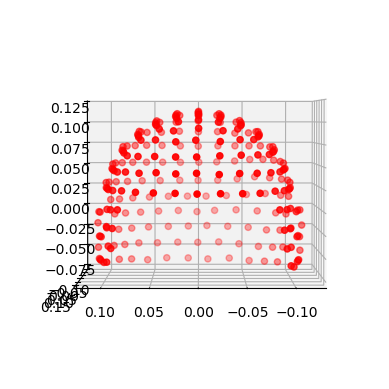

In [49]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sensor_coords[:, 0], sensor_coords[:, 1], sensor_coords[:, 2], c='r', marker='o')
ax.view_init(elev=2, azim=90)  # Change the elevation and azimuthal angle as needed

In [ ]:
sca_x = np.where(sensor_coords[:, 0] <= 0)[0]

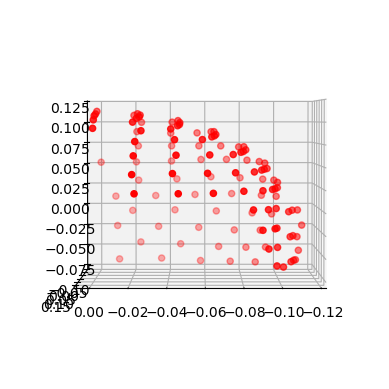

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sensor_coords[sca_x, 0], sensor_coords[sca_x, 1], sensor_coords[sca_x, 2], c='r', marker='o')
ax.view_init(elev=2, azim=90)  # Change the elevation and azimuthal angle as needed


In [138]:
sca_x = np.where(sensor_coords[:, 0] <= 0)[0]
sca_y = np.where((sensor_coords[:, 1] <= 0.125) & (sensor_coords[:, 1] >= -0.05))[0]
sca_z = np.where(sensor_coords[:, 2] <= 0.055)[0]

In [139]:
sca_indices = np.intersect1d(sca_x, sca_y)
sca_indices = np.intersect1d(sca_indices, sca_z)
other_indices = np.setdiff1d(np.arange(len(sensor_coords)), sca_indices)

In [ ]:
candidate_channels = []
for channel in sca_indices:
    candidate_channels.append((sample.info['ch_names'][channel], sensor_coords[channel]))

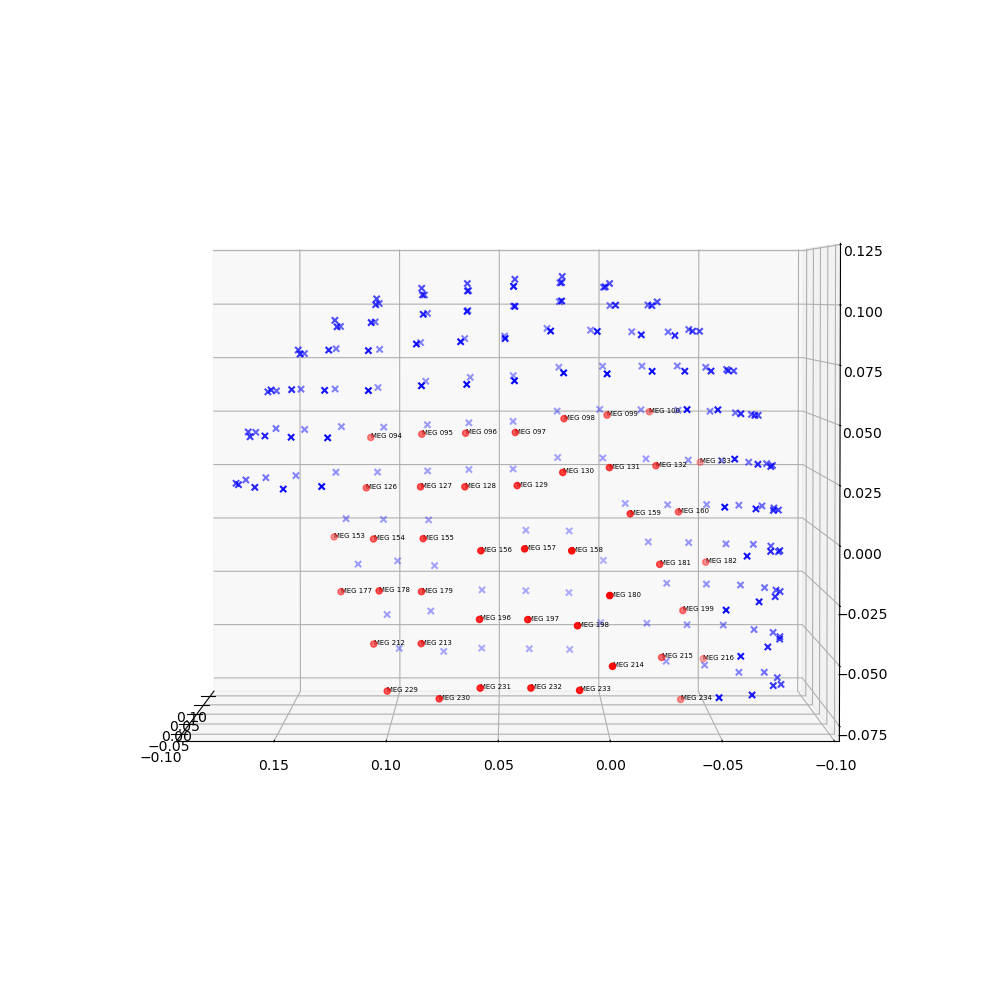

In [158]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sensor_coords[sca_indices, 0], sensor_coords[sca_indices, 1], sensor_coords[sca_indices, 2], c='r', marker='o')
ax.scatter(sensor_coords[other_indices, 0], sensor_coords[other_indices, 1], sensor_coords[other_indices, 2], c='b', marker='x')

for channel, coords in candidate_channels:
    ax.text(coords[0], coords[1], coords[2], channel, fontsize=5)


ax.view_init(elev=2, azim=180)  # Change the elevation and azimuthal angle as needed
fig.tight_layout()


In [178]:
chosen_channels = [
    94, 95, 126, 127, 155, 
    179, 213, 229, 196, 197, 
    198, 180, 181, 199, 182,
    160, 159, 132, 131, 130,
    129, 128, 156, 157, 158
]

chosen_channels = ["MEG 0" + str(ch) if ch < 100 else "MEG " + str(ch) for ch in chosen_channels]
chosen_with_coords = []
for channel, coords in candidate_channels:
    if channel in chosen_channels:
        chosen_with_coords.append((channel, coords)) 

In [239]:
chosen_with_coords[2][0]
chosen_channels

['MEG 094',
 'MEG 095',
 'MEG 126',
 'MEG 127',
 'MEG 155',
 'MEG 179',
 'MEG 213',
 'MEG 229',
 'MEG 196',
 'MEG 197',
 'MEG 198',
 'MEG 180',
 'MEG 181',
 'MEG 199',
 'MEG 182',
 'MEG 160',
 'MEG 159',
 'MEG 132',
 'MEG 131',
 'MEG 130',
 'MEG 129',
 'MEG 128',
 'MEG 156',
 'MEG 157',
 'MEG 158']

In [222]:
indices = []
for channel, coords in chosen_with_coords:
    indices.append(np.where(np.array(sample.info['ch_names']) == channel)[0][0])

other_indices = np.setdiff1d(np.arange(len(sensor_coords)), indices)


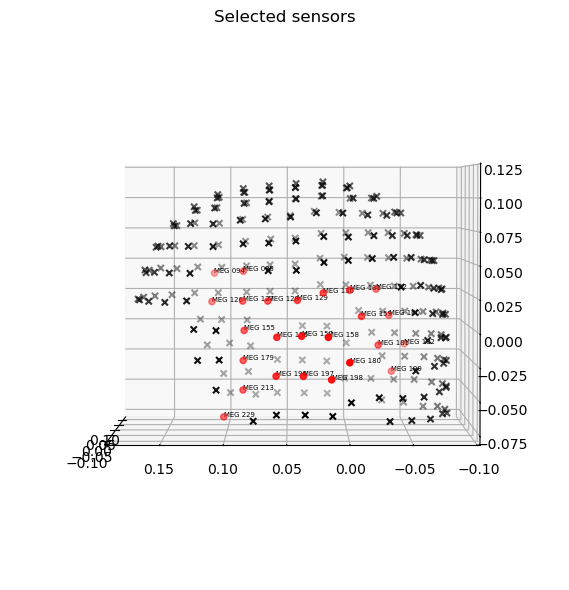

In [238]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sensor_coords[indices, 0], sensor_coords[indices, 1], sensor_coords[indices, 2], c='r', marker='o')
ax.scatter(sensor_coords[other_indices, 0], sensor_coords[other_indices, 1], sensor_coords[other_indices, 2], c='black', marker='x')

for channel, coords in chosen_with_coords:
    ax.text(coords[0], coords[1], coords[2], channel, fontsize=5)


ax.view_init(elev=2, azim=180)  # Change the elevation and azimuthal angle as needed
ax.set_title('Selected sensors')
fig.tight_layout()


In [240]:
subjects = ['BCOM_18_2'] # focus on one because the head thing for the mutliple trials is not working atm. 
avoid_reading = True
curated_data = BcomMEG(dir=dir, subjects=subjects, picks=chosen_channels, avoid_reading=avoid_reading)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_116-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
16 matching events found
No baseline correct

In [244]:
curated_data.data['BCOM_18_2']['re_144'].info['ch_names']

['MEG 094',
 'MEG 095',
 'MEG 126',
 'MEG 127',
 'MEG 155',
 'MEG 179',
 'MEG 213',
 'MEG 229',
 'MEG 196',
 'MEG 197',
 'MEG 198',
 'MEG 180',
 'MEG 181',
 'MEG 199',
 'MEG 182',
 'MEG 160',
 'MEG 159',
 'MEG 132',
 'MEG 131',
 'MEG 130',
 'MEG 129',
 'MEG 128',
 'MEG 156',
 'MEG 157',
 'MEG 158']

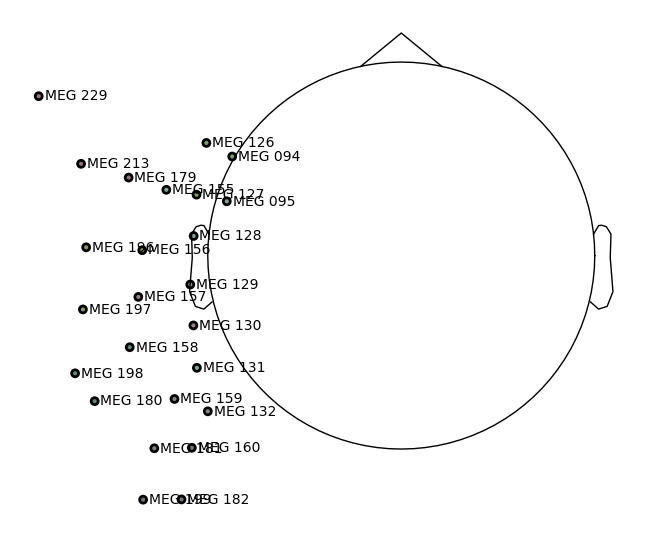

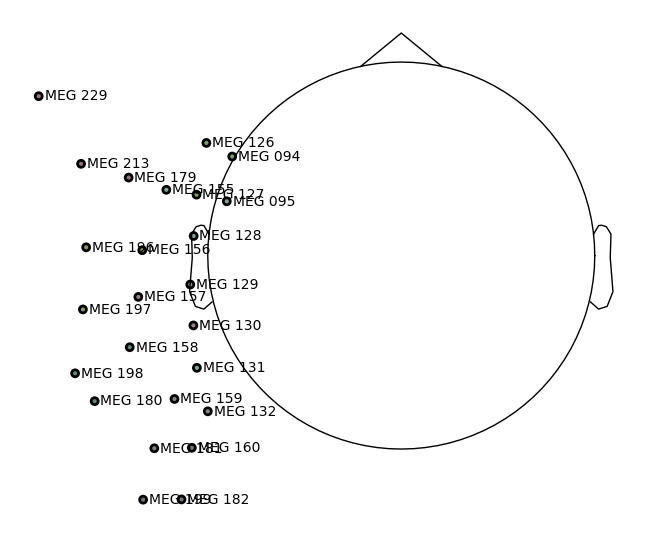

In [261]:
data.data['BCOM_18_2']['re_144'].pick(chosen_channels).plot_sensors(kind='topomap', ch_groups='position', show_names=True)

In [265]:
curated_sample = curated_data.data['BCOM_18_2']['re_144'].get_data()

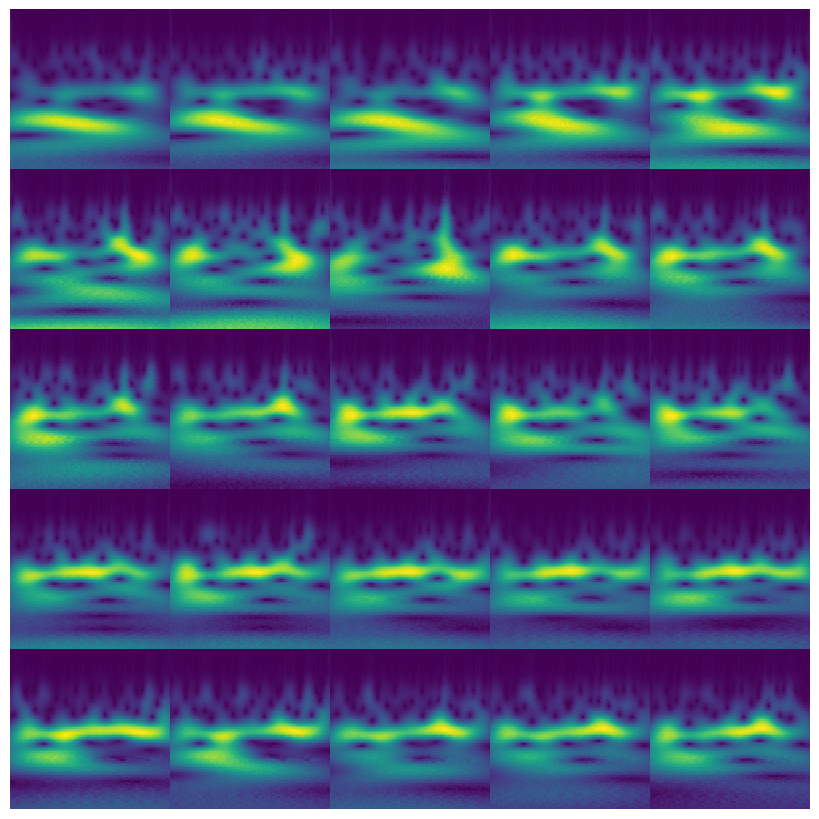

In [271]:
import pywt
processed_epochs = np.zeros_like(curated_sample)
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
for idx in range(curated_sample.shape[1]):
        r, c = divmod(idx, 5)
        signal = curated_sample[0, idx, :]
        processed_epochs[0, idx, :] = scalogram_dereconstruction(signal, wavelet='db4', level=5)
        coefficients = scalogram_cwt(processed_epochs[0, idx, :], B=1.0, C=1.0, wavelet='cmor', sampling_rate=300, log_samples=100)
        axes[r, c].pcolormesh(np.abs(coefficients), cmap='viridis')
        # axes[r, c].set_title(f"Ch {idx}")
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
fig.patch.set_visible(False)
# plt.savefig('scalogram.png', dpi=224) #9.1 seconds, dpi and size are 8x torch size
plt.show()